In [1]:
!pwd

/home/yiyi/Documents/master-computerlinguistik/ss2019/praktikum-bigdatascience/superresoluton/notebooks


In [2]:
data_path = '/home/yiyi/Documents/master-computerlinguistik/ss2019/praktikum-bigdatascience/superresoluton/data/interim/separated_data/labeled/'
image_path = data_path+ 'images'
xml_path = data_path + 'xmls'

In [3]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()
tf.VERSION

'1.14.1-dev20190516'

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
# retrieve the images

import pathlib
image_root = pathlib.Path(image_path)
print(image_root)

/home/yiyi/Documents/master-computerlinguistik/ss2019/praktikum-bigdatascience/superresoluton/data/interim/separated_data/labeled/images


In [7]:
image_data_names = list()
for item in image_root.iterdir():
    image_data_names.append(str(item).split('/')[-1].replace('.JPG',''))

len(image_data_names), image_data_names[1] # check all the gelabelte images

(2724, 's466_5m-1708-gelabelt-DJI_0022-DJI_0022-2560-1024')

In [66]:
import xml.etree.ElementTree as ET
from collections import defaultdict

# build a dictionary {imagefile: coordinates of bounding boxes}
label_dict=defaultdict(list)

for filename in image_data_names:    
    xmlfile= xml_path+'/'+filename+'.xml'
    try:
        root = ET.parse(xmlfile).getroot()
        
        for obj in root.iter('object'):
            if obj.find('name').text=='seedling':
                bndbox = obj.find('bndbox')
                xmin= int(bndbox.find('xmin').text)
                ymin= int(bndbox.find('ymin').text)
                xmax= int(bndbox.find('xmax').text)
                ymax= int(bndbox.find('ymax').text)
                
                label_dict[filename].append((xmin,ymin,xmax,ymax))
    except:
            print('falire')
            continue



In [67]:
import json
# output dictionary of image and its seedlings coordinates
with open('coords_dict.json','w')as fp:
    json.dump(label_dict, fp) 

/home/yiyi/Documents/master-computerlinguistik/ss2019/praktikum-bigdatascience/superresoluton/data/interim/separated_data/labeled/images/s464_5m-1710-gelabelt-DJI_0042-DJI_0042-1024-512.JPG


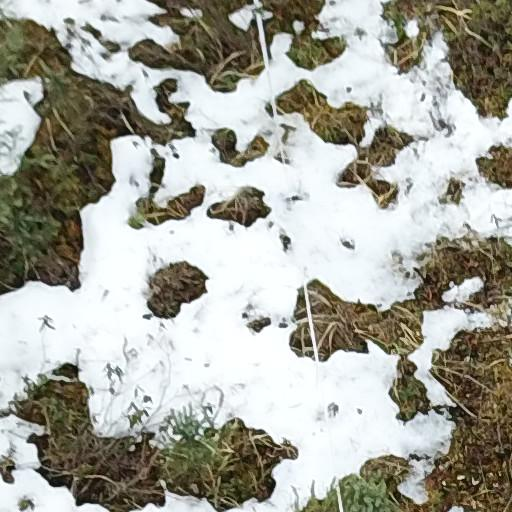

[(164, 404, 222, 467), (333, 469, 394, 512)]


In [14]:
import IPython.display as display
import random

for n in range(1):
    image_name= random.choice(image_data_names)
    image_file = image_path +'/'+ image_name+'.JPG'
    print(image_file)
    display.display(display.Image(image_file))
    print(label_dict[image_name])
    

In [10]:
# load and format the images
img_name = image_data_names[1]
image_file = image_path +'/'+ img_name+'.JPG'

img_raw = tf.read_file(image_file) # read file
img_tensor = tf.image.decode_image(img_raw) # decode into an image tensor
img_tensor.shape, img_tensor.dtype 

(TensorShape([Dimension(512), Dimension(512), Dimension(3)]), tf.uint8)

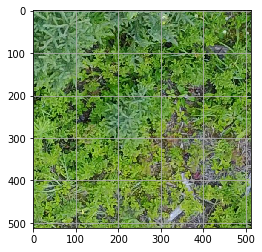

In [13]:
import matplotlib.pyplot as plt 

plt.imshow(img_tensor)
plt.grid(True)
print()

## Build a tf.data.Dataset

In [25]:
# image_root, build all image path
all_images_labeled =list(set( [str(file) for file in image_root.glob('**/*.JPG')]))
len(all_images_labeled), all_images_labeled[0]

(2724,
 '/home/yiyi/Documents/master-computerlinguistik/ss2019/praktikum-bigdatascience/superresoluton/data/interim/separated_data/labeled/images/s466_5m-1710-gelabelt-DJI_0042-DJI_0042-3072-1536.JPG')

In [30]:
# slicing the array of strings, results in a dataset of strings
path_ds = tf.data.Dataset.from_tensor_slices(all_images_labeled)

In [31]:
repr(path_ds.output_shapes), path_ds.output_types

('TensorShape([])', tf.string)

In [45]:
# Now create a new dataset that loads and formats images on the fly by mapping preprocess_image over the dataset of paths
def process_image(path):
    image=tf.read_file(path)
    image=tf.image.decode_image(image)
    return image

def caption_image(path):
    name = path.split('/')[-1].replace('.JPG','')
    return label_dict[name]

image_ds = path_ds.map(process_image, num_parallel_calls= AUTOTUNE)

image path: /home/yiyi/Documents/master-computerlinguistik/ss2019/praktikum-bigdatascience/superresoluton/data/interim/separated_data/labeled/images/s464_5m-1710-gelabelt-DJI_0001-DJI_0001-2560-1024.JPG
[(129, 180, 410, 417), (365, 420, 466, 497), (409, 69, 491, 132)]


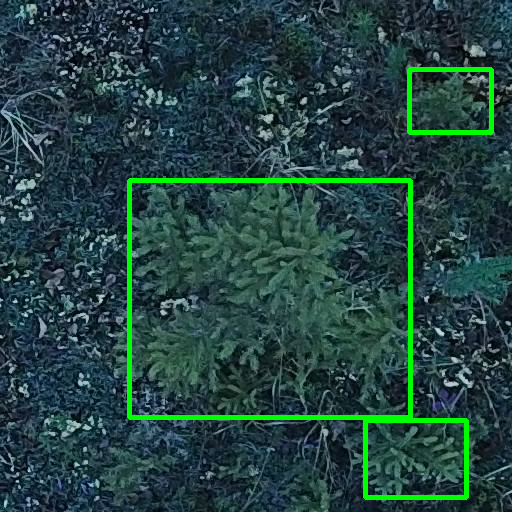

In [62]:
# draw bounding box
import cv2
import pandas
from PIL import Image

def get_coords(image_path):
    name = image_path.split('/')[-1].replace('.JPG','')
    return label_dict[name]
    
def draw_boxes(image_path):
    print('image path:', image_path)
    selected_values= get_coords(image_path)
    print(selected_values)
    img = cv2.imread(image_path)
    for index, row in enumerate(selected_values):
        img= cv2.rectangle(img, (row[0],row[1]),(row[2],row[3]), (0,255,0),3)
    return img

Image.fromarray(draw_boxes(all_images_labeled[100])) # change the number to see different images

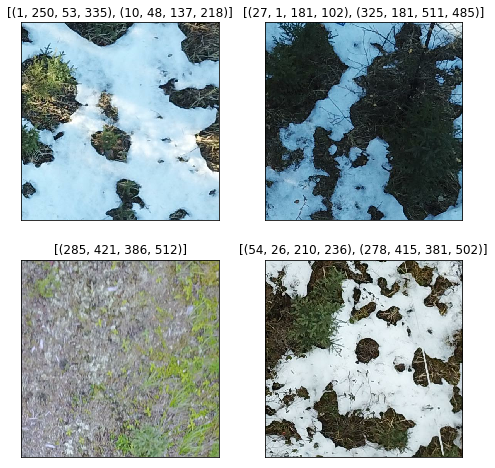

In [46]:
plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.title(caption_image(all_images_labeled[n])) # labels are coordinates of the seedlings.